## Import Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL 
import tensorflow as tf
#import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib
import os
import plotly.express as px
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, accuracy_score,confusion_matrix

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall
from glob import glob
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.layers import Lambda, SeparableConv2D, BatchNormalization, Dropout, MaxPooling2D, Input, Dense, Conv2D, Activation, Flatten 
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D,BatchNormalization,MaxPool2D,Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import imageio
#from scipy.signal import convolve2dro 

import matplotlib.image as mpimg
from tensorflow.keras.preprocessing import image

## Importing and analysing Data

In [2]:
prec=[]             # to store all precisions of the applied classifiers
rcl=[]              # to store all recalls of the applied classifiers
f1=[]               # to store all f1-score of the applied classifiers
acc=[]              # to store all accuracies of the applied classifiers
rawlink="D:/Covid19-dataset/"
train_path=rawlink+"train"
test_path=rawlink+"test"
train_dir = pathlib.Path(train_path)
test_dir = pathlib.Path(test_path)
labels=os.listdir(test_dir)
print("Labels in the Data:",*labels, sep=", ")

Labels in the Data:, Covid, Normal, Viral Pneumonia


### Image Data Splitting

In [3]:
train_count = len(list(train_dir.glob('*/*.*')))
test_count = len(list(test_dir.glob('*/*.*')))

print(" ======================================")
print("  Images in Training set : {} \n  Images in Test det : {}".format(train_count,test_count))
print(" ======================================")
cats=["Train","Test"]
vals=[train_count, test_count]
valdf=pd.DataFrame({"Directories":cats,"Count":vals})
fig=px.pie(valdf,names="Directories",values="Count",color="Directories",
           title="Images in Train and Test Directories",height=600,width=600)
fig.update_traces(textposition='inside',textinfo='percent+label')
fig.update_layout(
    font=dict(
        family="Times New Roman, Bold",
        size=20,
        color="black"
    )
)
fig.show()

  Images in Training set : 251 
  Images in Test det : 66


In [4]:
trn=os.listdir(train_dir)
tst=os.listdir(test_dir)
trdata=[]
tsdata=[]
types=['Covid', 'Normal', 'Viral Pneumonia']
for i in trn:
    trdata.append(len(os.listdir(os.path.join(train_dir,i))))
for i in tst:
    tsdata.append(len(os.listdir(os.path.join(test_dir,i))))
xrayimages=pd.DataFrame({"Category":types,"Train":trdata,"Test":tsdata})
for i in range(len(xrayimages)):
    print("======================================================")
    print("  Available training images in {} is {}".format(xrayimages['Category'][i],xrayimages['Train'][i]))
    print("  Available test images in {} is {}".format(xrayimages['Category'][i],xrayimages['Test'][i]))
print("======================================================")

  Available training images in Covid is 111
  Available test images in Covid is 26
  Available training images in Normal is 70
  Available test images in Normal is 20
  Available training images in Viral Pneumonia is 70
  Available test images in Viral Pneumonia is 20


In [5]:
fig=px.pie(xrayimages,names="Category",values="Train",color="Category",title="Number of Images Train Set",height=600,width=600)
fig.update_traces(textposition='inside',textinfo='percent+label')
fig.update_layout(
    font=dict(
        family="Times New Roman, Bold",
        size=20,
        color="purple"
    )
)
fig.show()

In [6]:
fig=px.pie(xrayimages,names="Category",values="Test",color="Category",title="Number of Images Test Set",height=600,width=600)
fig.update_traces(textposition='inside',textinfo='percent+label')
fig.update_layout(
    font=dict(
        family="Times New Roman, Bold",
        size=20,
        color="purple"
    )
)
fig.show()

In [8]:
covid_train = list(train_dir.glob("Covid/*"))
pnemonia_train = list(train_dir.glob("Viral Pneumonia/*"))
normal_train = list(train_dir.glob("Normal/*"))

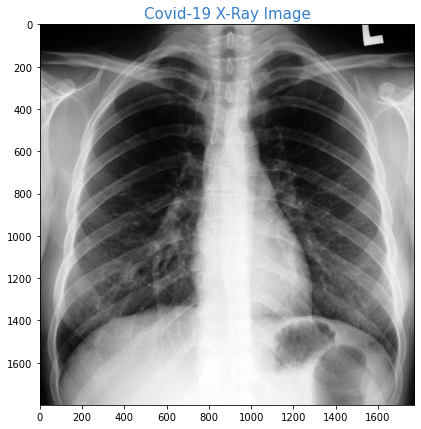

In [9]:
covid_img = PIL.Image.open(covid_train[21])        # using pillow library
plt.figure(figsize=(7,7))
plt.title("Covid-19 X-Ray Image",fontsize=15,color="#357EC7")
plt.imshow(covid_img)

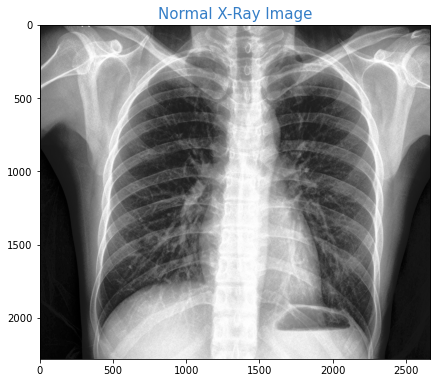

In [10]:
normal_img = PIL.Image.open(normal_train[20])
plt.figure(figsize=(7,7))
plt.title("Normal X-Ray Image",fontsize=15,color="#357EC7")
plt.imshow(normal_img)

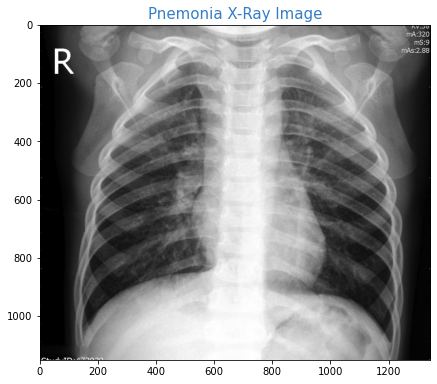

In [11]:
pnemonia_img = PIL.Image.open(pnemonia_train[12])
plt.figure(figsize=(7,7))
plt.title("Pnemonia X-Ray Image",fontsize=15,color="#357EC7")
plt.imshow(pnemonia_img)

## Load in tensorflow and preprocessing

https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

In [12]:
# ImageDataGenerator is used to transform the image to image array
# constructor
train_datagen = ImageDataGenerator(rescale=1. / 255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1. / 255)

In [13]:
batch_size = 16    
img_h = 300
img_w = 300

In [14]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  image_size=(img_h, img_w),
  batch_size=batch_size)
train_generator = train_datagen.flow_from_directory(
        train_path,
        classes=labels,
        target_size=(img_h, img_w),
        batch_size=32,
        class_mode='categorical')

Found 251 files belonging to 3 classes.
Found 251 images belonging to 3 classes.


In [15]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    image_size =(img_h,img_w),
    batch_size = batch_size)
test_generator = test_datagen.flow_from_directory(
        test_path,
        classes=labels,
        target_size=(img_h,img_w),
        batch_size=32,
        class_mode='categorical')

Found 66 files belonging to 3 classes.
Found 66 images belonging to 3 classes.


In [16]:
class_names = train_ds.class_names
print(class_names)

['Covid', 'Normal', 'Viral Pneumonia']


## Visualizing the dataset

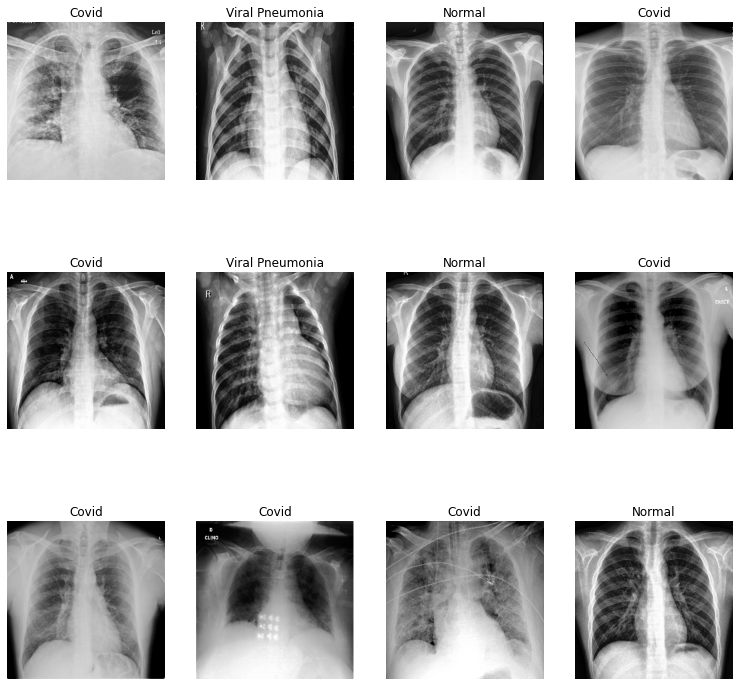

In [65]:
totplot=12
plt.figure(figsize=(13, 13))
for images, labels in train_ds.take(1):
    for i in range(totplot):
        ax = plt.subplot(int(totplot/4), int(totplot/3), i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [66]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(16, 300, 300, 3)
(16,)


In [17]:
normalizing_layer = layers.experimental.preprocessing.Rescaling(1./255)

## Keras Sequencial Model for CNN

In [ ]:
[0.45,0.22,0.78]           argmax([0.45,0.22,0.78]) => 2

In [19]:
num_classes = 3

model_sq = Sequential([
    normalizing_layer,
    layers.Conv2D(16,3, padding = "same", activation = "relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(32,3, padding = "same", activation = "relu"),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128,activation = "relu"),
    layers.Dense(num_classes),
    layers.Activation('softmax')
])                                   # Relu-> rectified linear unit

In [69]:
model_sq.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])   #tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [70]:
epochs=30
history_sq = model_sq.fit(
  train_generator,
  batch_size=16,
  validation_data=test_generator,
  epochs=epochs)

Epoch 1/30
8/8 [==============================] - 47s 5s/step - loss: 1.0762 - accuracy: 0.4024 - val_loss: 1.0940 - val_accuracy: 0.3182
Epoch 2/30
8/8 [==============================] - 23s 3s/step - loss: 1.0726 - accuracy: 0.4303 - val_loss: 1.0292 - val_accuracy: 0.3939
Epoch 3/30
8/8 [==============================] - 27s 3s/step - loss: 1.0184 - accuracy: 0.4821 - val_loss: 0.9507 - val_accuracy: 0.5455
Epoch 4/30
8/8 [==============================] - 29s 4s/step - loss: 0.9363 - accuracy: 0.5936 - val_loss: 0.8205 - val_accuracy: 0.6061
Epoch 5/30
8/8 [==============================] - 29s 4s/step - loss: 0.8284 - accuracy: 0.6255 - val_loss: 0.7529 - val_accuracy: 0.6061
Epoch 6/30
8/8 [==============================] - 32s 4s/step - loss: 0.7698 - accuracy: 0.6534 - val_loss: 0.7924 - val_accuracy: 0.5758
Epoch 7/30
8/8 [==============================] - 31s 4s/step - loss: 0.8254 - accuracy: 0.6255 - val_loss: 0.6934 - val_accuracy: 0.6515
Epoch 8/30
8/8 [==================

In [22]:
model_sq.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, None, None, None)  0         
_________________________________________________________________
conv2d (Conv2D)              (None, None, None, 16)    448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, None, None, 16)    0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 32)    4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, None, None, 32)    0         
_________________________________________________________________
flatten (Flatten)            (None, None)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               2

In [23]:
train_acc = history_sq.history['accuracy']
test_acc = history_sq.history['val_accuracy']
train_loss = history_sq.history['loss']
test_loss = history_sq.history['val_loss']
model_stat_sq=pd.DataFrame({
    "Epoch":[i+1 for i in range(30)],
    "Training Loss":train_loss,
    "Test Loss":test_loss,
    "Training Accuracy":train_acc,
    "Test Accuracy":test_acc
})
model_stat_sq.to_csv("model_sq.csv")
model_stat_sq

Epoch  Training Loss  Test Loss  Training Accuracy  Test Accuracy
0       1       1.093511   1.064088           0.438247       0.393939
1       2       1.030963   0.983969           0.458167       0.606061
2       3       0.983289   0.924489           0.557769       0.651515
3       4       0.907635   0.824501           0.609562       0.651515
4       5       0.777980   0.681579           0.697211       0.621212
5       6       0.752152   0.696295           0.649402       0.636364
6       7       0.790911   0.858083           0.649402       0.590909
7       8       0.718561   0.604868           0.677291       0.666667
8       9       0.687634   0.739549           0.689243       0.590909
9      10       0.668824   0.721421           0.677291       0.590909
10     11       0.711050   0.594659           0.689243       0.666667
11     12       0.739032   0.665156           0.689243       0.666667
12     13       0.729002   0.644616           0.693227       0.636364
13     14       0.655315   0.621902           0.721116       0.681818
14     15       0.658404   0.699260           0.725100       0.590909
15     16       0.650346   0.567952           0.713147       0.712121
16     17       0.752446   0.598736           0.653386       0.696970
17     18       0.651651   0.607569           0.717131       0.712121
18     19       0.638426   0.627480           0.745020       0.681818
19     20       0.625443   0.576491           0.745020       0.727273
20     21       0.692395   0.586291           0.697211       0.727273
21     22       0.660512   0.742754           0.721116       0.590909
22     23       0.680358   0.598633           0.701195       0.696970
23     24       0.657443   0.594474           0.717131       0.636364
24     25       0.678592   0.700683           0.677291       0.590909
25     26       0.682262   0.615906           0.693227       0.651515
26     27       0.645159   0.590101           0.741036       0.696970
27     28       0.723091   0.689016           0.685259       0.575758
28     29       0.657930   0.612884           0.733068       0.681818
29     30       0.619839   0.603911           0.717131       0.681818

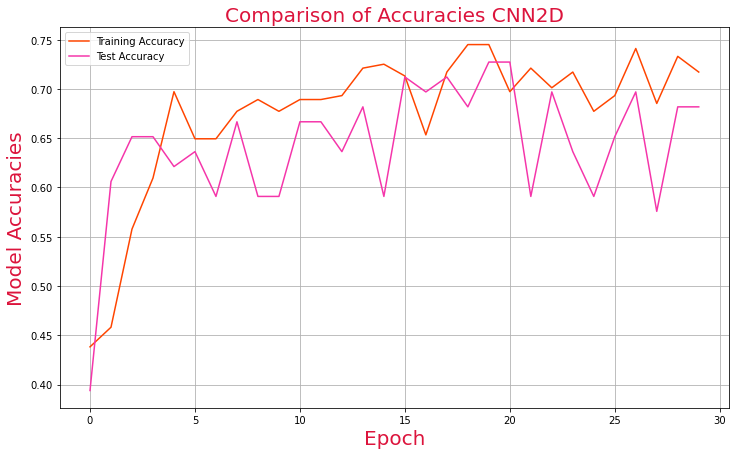

In [24]:
collist=["#FF4500","#F535AA"]
model_stat_sq.iloc[:,3:].plot(kind="line",figsize=(12,7),color=collist)
plt.title("Comparison of Accuracies CNN2D",fontsize=20,color="#DC143C")
plt.xlabel("Epoch",fontsize=20,color="#DC143C")
plt.ylabel("Model Accuracies",fontsize=20,color="#DC143C")
plt.grid()
plt.show()

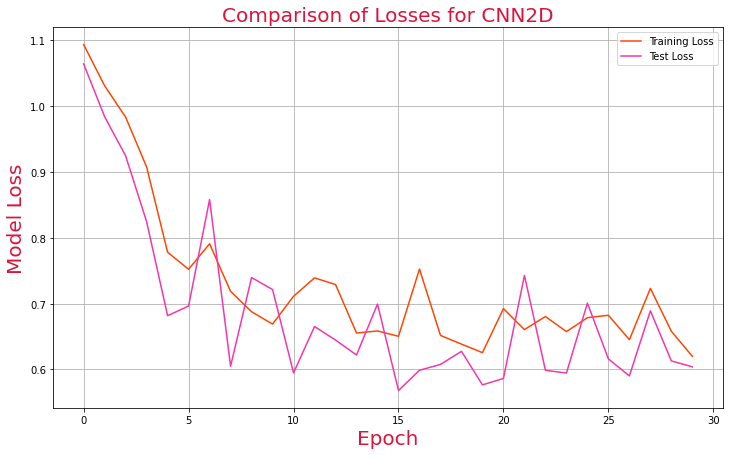

In [25]:
model_stat_sq.iloc[:,1:3].plot(kind="line",figsize=(12,7),color=collist)
plt.title("Comparison of Losses for CNN2D",fontsize=20,color="#DC143C")
plt.xlabel("Epoch",fontsize=20,color="#DC143C")
plt.ylabel("Model Loss",fontsize=20,color="#DC143C")
plt.grid()
plt.show()

In [26]:
y_pred = model_sq.predict(train_generator)
y_pred = np.argmax(y_pred, axis=1)
class_labels = train_generator.classes
sq_out=pd.DataFrame({"Actual":class_labels,"Predicted":y_pred})     # dataframe for actual and predicted
sq_out["Actual"]=sq_out["Actual"].replace(sq_out["Actual"].unique(),['Covid', 'Normal', 'Viral Pneumonia'])
sq_out["Predicted"]=sq_out["Predicted"].replace(sq_out["Predicted"].unique(),['Covid', 'Normal', 'Viral Pneumonia'])
prec.append(round(precision_score(sq_out["Actual"], sq_out["Predicted"], average='micro'),2)*100)     # Precision of the model
rcl.append(round(recall_score(sq_out["Actual"], sq_out["Predicted"], average='micro'),2)*100)     # Recall of the model
f1.append(round(f1_score(sq_out["Actual"], sq_out["Predicted"], average='micro'),2)*100)     # F1-Score of the model
acc.append(round(model_stat_sq['Training Accuracy'].max(),4)*100)
print("Accuracy for CNN Model => {}%".format(round(model_stat_sq['Training Accuracy'].max(),4)*100))
ct_sq=pd.crosstab(sq_out["Actual"], sq_out["Predicted"], rownames=['True'], colnames=['Predicted'], margins=True)
ct_sq.iloc[:3,:3]

Accuracy for CNN Model => 74.5%


Predicted        Covid  Normal  Viral Pneumonia
True                                           
Covid               47      39               25
Normal              35      22               13
Viral Pneumonia     38      16               16

In [22]:
lbldir=os.listdir(test_path)
print(lbldir)
os.listdir(test_path+"/"+lbldir[1])[0]

['Covid', 'Normal', 'Viral Pneumonia']


'0101.jpeg'

['Covid', 'Normal', 'Viral Pneumonia']
Covid Affected Chest X-Ray Image


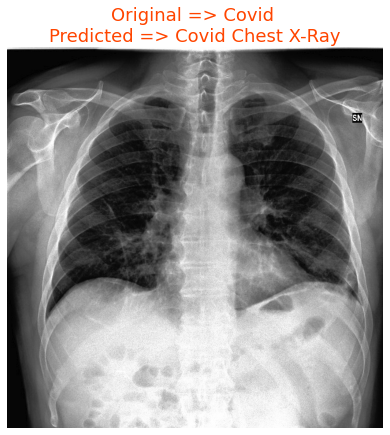

Normal Chest X-Ray Image


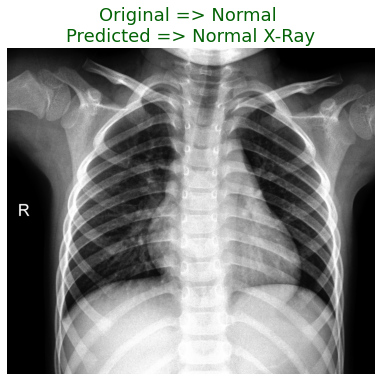

Viral Pneumonia Affected Chest X-Ray Image


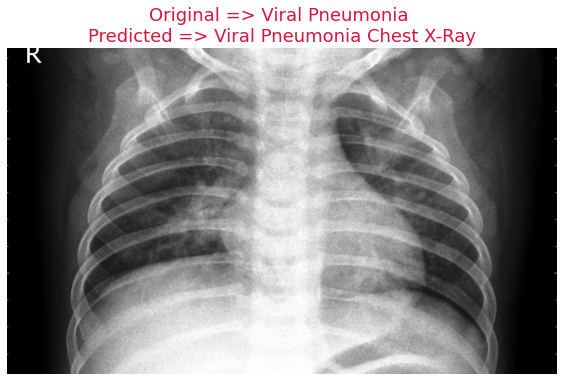

In [27]:
def chest_prediction(pres,dr):
    im = mpimg.imread(pres)     # reading images
    img = image.load_img(pres,target_size=(img_h,img_w))      # reading images
    img = image.img_to_array(img)     # converting present image to array
    img = np.expand_dims(img,axis=0)   
    pred=model_sq.predict(img)    # predict images
    pred_1=np.argmax(pred, axis=1)
    if pred_1[0]==0:
        print("Covid Affected Chest X-Ray Image")
        plt.figure(figsize=(14,7))
        picpred=imageio.imread(pres)
        plt.title("Original => {} \nPredicted => Covid Chest X-Ray".format(dr),fontsize=18,color="#FF4500")
        plt.imshow(picpred)
        plt.axis('off')
        plt.show()
    elif pred_1[0]==1:
        print("Normal Chest X-Ray Image")
        plt.figure(figsize=(12,6))
        picpred=imageio.imread(pres)
        plt.title("Original => {} \nPredicted => Normal X-Ray".format(dr),fontsize=18,color="#046307")
        plt.imshow(picpred)
        plt.axis('off')
        plt.show()
    elif pred_1[0]==2:
        print("Viral Pneumonia Affected Chest X-Ray Image")
        plt.figure(figsize=(12,6))
        picpred=imageio.imread(pres)
        plt.title("Original => {} \nPredicted => Viral Pneumonia Chest X-Ray".format(dr),fontsize=18,color="#DC143C")
        plt.imshow(picpred)
        plt.axis('off')
        plt.show()
    
lbldir=os.listdir(test_path)
print(lbldir)
pres=os.path.join(test_path,lbldir[0],os.listdir(test_path+"/"+lbldir[0])[0])
chest_prediction(pres,lbldir[0])
pres=os.path.join(test_path,lbldir[1],os.listdir(test_path+"/"+lbldir[1])[0])
chest_prediction(pres,lbldir[1])
pres=os.path.join(test_path,lbldir[2],os.listdir(test_path+"/"+lbldir[2])[4])
chest_prediction(pres,lbldir[2])

In [28]:
model_sq.save('pneumonia_model_seq.h5')

## VGG Model for CNN

In [29]:
vgg = VGG16(input_shape=[img_h,img_w] + [3], weights='imagenet', include_top=False)
for layer in vgg.layers:
    layer.trainable=False
folders=glob('D:/Datasets/Covid_Chest_Data_XRAY/Covid_Chest/Covid19-dataset/train/*')
x=Flatten()(vgg.output)
prediction=Dense(3,activation='softmax')(x)
model_vgg = Model(inputs=vgg.input, outputs=prediction)
model_vgg.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)
model_vgg.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 300, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 150, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 75, 75, 128)       0     

In [31]:
history_vgg = model_vgg.fit(
  train_generator,
  batch_size=16,
  validation_data=test_generator,
  epochs=10
)

Epoch 1/10
8/8 [==============================] - 161s 21s/step - loss: 0.1706 - accuracy: 0.9602 - val_loss: 0.2559 - val_accuracy: 0.9394
Epoch 2/10
8/8 [==============================] - 165s 20s/step - loss: 0.2094 - accuracy: 0.9084 - val_loss: 0.2246 - val_accuracy: 0.9394
Epoch 3/10
8/8 [==============================] - 162s 20s/step - loss: 0.1943 - accuracy: 0.9323 - val_loss: 0.2145 - val_accuracy: 0.9242
Epoch 4/10
8/8 [==============================] - 156s 19s/step - loss: 0.1721 - accuracy: 0.9562 - val_loss: 0.2068 - val_accuracy: 0.9394
Epoch 5/10
8/8 [==============================] - 160s 20s/step - loss: 0.1826 - accuracy: 0.9402 - val_loss: 0.2438 - val_accuracy: 0.9394
Epoch 6/10
8/8 [==============================] - 147s 18s/step - loss: 0.1592 - accuracy: 0.9442 - val_loss: 0.4026 - val_accuracy: 0.8030
Epoch 7/10
8/8 [==============================] - 151s 19s/step - loss: 0.1983 - accuracy: 0.9323 - val_loss: 0.2490 - val_accuracy: 0.9242
Epoch 8/10
8/8 [====

In [32]:
train_acc = history_vgg.history['accuracy']
test_acc = history_vgg.history['val_accuracy']
train_loss = history_vgg.history['loss']
test_loss = history_vgg.history['val_loss']
model_stat_vgg=pd.DataFrame({
    "Epoch":[i+1 for i in range(10)],
    "Training Loss":train_loss,
    "Test Loss":test_loss,
    "Training Accuracy":train_acc,
    "Test Accuracy":test_acc
})
model_stat_vgg.to_csv("model_vgg.csv")
model_stat_vgg

Epoch  Training Loss  Test Loss  Training Accuracy  Test Accuracy
0      1       0.170643   0.255871           0.960159       0.939394
1      2       0.209388   0.224574           0.908367       0.939394
2      3       0.194287   0.214540           0.932271       0.924242
3      4       0.172104   0.206777           0.956175       0.939394
4      5       0.182616   0.243796           0.940239       0.939394
5      6       0.159244   0.402577           0.944223       0.803030
6      7       0.198313   0.248989           0.932271       0.924242
7      8       0.136215   0.254699           0.956175       0.924242
8      9       0.168789   0.214097           0.948207       0.924242
9     10       0.126120   0.301469           0.948207       0.909091

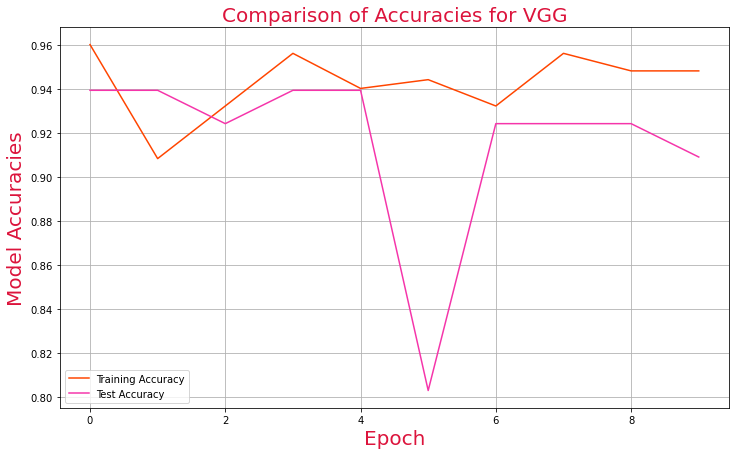

In [33]:
collist=["#FF4500","#F535AA"]
model_stat_vgg.iloc[:,3:].plot(kind="line",figsize=(12,7),color=collist)
plt.title("Comparison of Accuracies for VGG",fontsize=20,color="#DC143C")
plt.xlabel("Epoch",fontsize=20,color="#DC143C")
plt.ylabel("Model Accuracies",fontsize=20,color="#DC143C")
plt.grid()
plt.show()

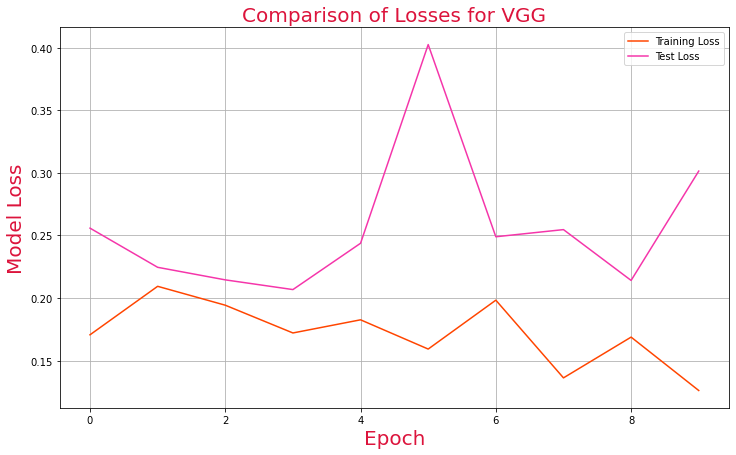

In [34]:
model_stat_vgg.iloc[:,1:3].plot(kind="line",figsize=(12,7),color=collist)
plt.title("Comparison of Losses for VGG",fontsize=20,color="#DC143C")
plt.xlabel("Epoch",fontsize=20,color="#DC143C")
plt.ylabel("Model Loss",fontsize=20,color="#DC143C")
plt.grid()
plt.show()

In [35]:
y_pred = model_vgg.predict(train_generator)
y_pred = np.argmax(y_pred, axis=1)
class_labels = train_generator.classes
vgg_out=pd.DataFrame({"Actual":class_labels,"Predicted":y_pred})
vgg_out["Actual"]=vgg_out["Actual"].replace(vgg_out["Actual"].unique(),['Covid', 'Normal', 'Viral Pneumonia'])
vgg_out["Predicted"]=vgg_out["Predicted"].replace(vgg_out["Predicted"].unique(),['Covid', 'Normal', 'Viral Pneumonia'])
prec.append(round(precision_score(vgg_out["Actual"], vgg_out["Predicted"], average='micro'),2)*100)     # Precision of the model
rcl.append(round(recall_score(vgg_out["Actual"], vgg_out["Predicted"], average='micro'),2)*100)     # Recall of the model
f1.append(round(f1_score(vgg_out["Actual"], vgg_out["Predicted"], average='micro'),2)*100)     # F1-Score of the model
acc.append(round(model_stat_vgg['Training Accuracy'].max(),4)*100)
print("Accuracy for VGG16 Model => {}".format(round(model_stat_vgg['Training Accuracy'].max(),4)*100))
ct_vgg=pd.crosstab(vgg_out["Actual"], vgg_out["Predicted"], rownames=['True'], colnames=['Predicted'], margins=True)
ct_vgg.iloc[:3,:3]

Accuracy for VGG16 Model => 96.02000000000001


Predicted        Covid  Normal  Viral Pneumonia
True                                           
Covid               29      46               36
Normal              20      29               21
Viral Pneumonia     14      35               21

['Covid', 'Normal', 'Viral Pneumonia']
Covid Affected Chest X-Ray Image


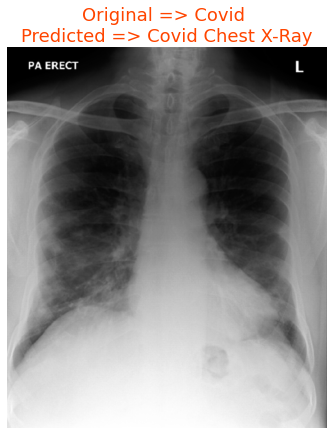

Normal Chest X-Ray Image


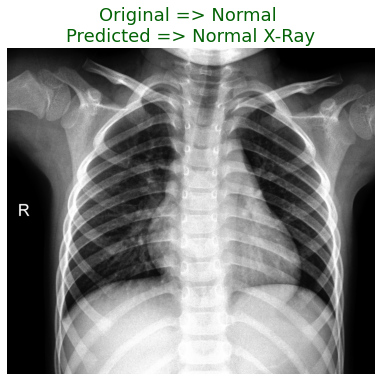

Viral Pneumonia Affected Chest X-Ray Image


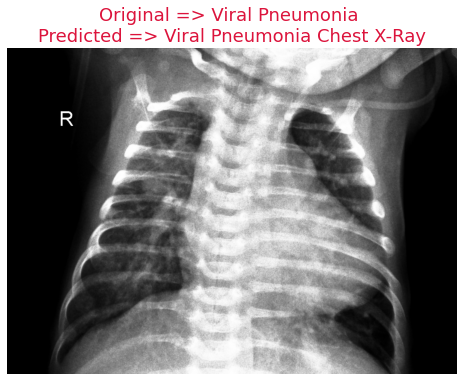

In [36]:
def chest_prediction(pres,dr):
    im = mpimg.imread(pres)
    img = image.load_img(pres,target_size=(img_h,img_w))
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis=0)
    pred=model_vgg.predict(img)
    pred_1=np.argmax(pred, axis=1)
    if pred_1[0]==0:
        print("Covid Affected Chest X-Ray Image")
        plt.figure(figsize=(14,7))
        picpred=imageio.imread(pres)
        plt.title("Original => {} \nPredicted => Covid Chest X-Ray".format(dr),fontsize=18,color="#FF4500")
        plt.imshow(picpred)
        plt.axis('off')
        plt.show()
    elif pred_1[0]==1:
        print("Normal Chest X-Ray Image")
        plt.figure(figsize=(12,6))
        picpred=imageio.imread(pres)
        plt.title("Original => {} \nPredicted => Normal X-Ray".format(dr),fontsize=18,color="#046307")
        plt.imshow(picpred)
        plt.axis('off')
        plt.show()
    elif pred_1[0]==2:
        print("Viral Pneumonia Affected Chest X-Ray Image")
        plt.figure(figsize=(12,6))
        picpred=imageio.imread(pres)
        plt.title("Original => {} \nPredicted => Viral Pneumonia Chest X-Ray".format(dr),fontsize=18,color="#DC143C")
        plt.imshow(picpred)
        plt.axis('off')
        plt.show()
    
lbldir=os.listdir(test_path)
print(lbldir)
pres=os.path.join(test_path,lbldir[0],os.listdir(test_path+"/"+lbldir[0])[1])
chest_prediction(pres,lbldir[0])
pres=os.path.join(test_path,lbldir[1],os.listdir(test_path+"/"+lbldir[1])[0])
chest_prediction(pres,lbldir[1])
pres=os.path.join(test_path,lbldir[2],os.listdir(test_path+"/"+lbldir[2])[2])
chest_prediction(pres,lbldir[2])

In [37]:
model_vgg.save('pneumonia_model_vgg.h5')

## DenseNet121 Model for CNN

In [39]:
trainset=[]
mapping={ 'Normal':0,'Viral Pneumonia':1,'Covid':2 }

In [40]:
den121 = tf.keras.applications.DenseNet121(input_shape=(img_h,img_w,3),include_top=False,weights='imagenet',pooling='avg')
den121.trainable = False

inputs_den =den121.input
x_den = tf.keras.layers.Dense(128, activation='relu')(den121.output)
outputs_den = tf.keras.layers.Dense(3, activation='softmax')(x_den)
model_den = tf.keras.Model(inputs=inputs_den, outputs=outputs_den)

model_den.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
history_den = model_den.fit(
  train_generator,
  batch_size=16,
  validation_data=test_generator,
  epochs=10
)

29097984/29084464 [==============================] - 6s 0us/step
Epoch 1/10
8/8 [==============================] - 70s 8s/step - loss: 0.9332 - accuracy: 0.5179 - val_loss: 0.6900 - val_accuracy: 0.7273
Epoch 2/10
8/8 [==============================] - 69s 9s/step - loss: 0.5796 - accuracy: 0.7570 - val_loss: 0.5991 - val_accuracy: 0.6515
Epoch 3/10
8/8 [==============================] - 68s 9s/step - loss: 0.4590 - accuracy: 0.8127 - val_loss: 0.5000 - val_accuracy: 0.8030
Epoch 4/10
8/8 [==============================] - 68s 9s/step - loss: 0.3578 - accuracy: 0.8725 - val_loss: 0.4489 - val_accuracy: 0.8333
Epoch 5/10
8/8 [==============================] - 66s 8s/step - loss: 0.2726 - accuracy: 0.9004 - val_loss: 0.3868 - val_accuracy: 0.8333
Epoch 6/10
8/8 [==============================] - 65s 8s/step - loss: 0.2500 - accuracy: 0.9084 - val_loss: 0.3532 - val_accuracy: 0.8636
Epoch 7/10
8/8 [==============================] - 72s 9s/step - loss: 0.2368 - accuracy: 0.9163 - val_loss:

In [41]:
model_den.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 306, 306, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 150, 150, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 150, 150, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

conv4_block11_1_bn (BatchNormal (None, 18, 18, 128)  512         conv4_block11_1_conv[0][0]       
__________________________________________________________________________________________________
conv4_block11_1_relu (Activatio (None, 18, 18, 128)  0           conv4_block11_1_bn[0][0]         
__________________________________________________________________________________________________
conv4_block11_2_conv (Conv2D)   (None, 18, 18, 32)   36864       conv4_block11_1_relu[0][0]       
__________________________________________________________________________________________________
conv4_block11_concat (Concatena (None, 18, 18, 608)  0           conv4_block10_concat[0][0]       
                                                                 conv4_block11_2_conv[0][0]       
__________________________________________________________________________________________________
conv4_block12_0_bn (BatchNormal (None, 18, 18, 608)  2432        conv4_block11_concat[0][0]       
__________

In [42]:
train_acc = history_den.history['accuracy']
test_acc = history_den.history['val_accuracy']
train_loss = history_den.history['loss']
test_loss = history_den.history['val_loss']
model_stat_den=pd.DataFrame({
    "Epoch":[i+1 for i in range(10)],
    "Training Loss":train_loss,
    "Test Loss":test_loss,
    "Training Accuracy":train_acc,
    "Test Accuracy":test_acc
})
model_stat_den.to_csv("model_vgg.csv")
model_stat_den

Epoch  Training Loss  Test Loss  Training Accuracy  Test Accuracy
0      1       0.933219   0.689959           0.517928       0.727273
1      2       0.579625   0.599058           0.756972       0.651515
2      3       0.458954   0.499989           0.812749       0.803030
3      4       0.357839   0.448949           0.872510       0.833333
4      5       0.272637   0.386794           0.900398       0.833333
5      6       0.250003   0.353170           0.908367       0.863636
6      7       0.236764   0.452859           0.916335       0.772727
7      8       0.235518   0.309559           0.920319       0.878788
8      9       0.179979   0.370793           0.952191       0.833333
9     10       0.200012   0.260062           0.916335       0.893939

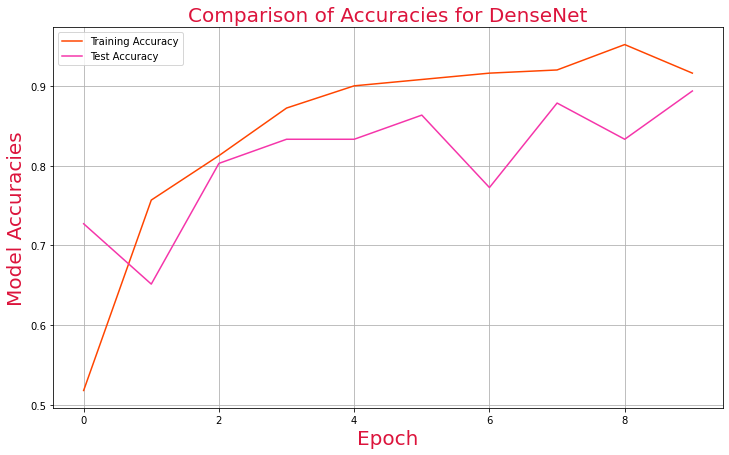

In [43]:
collist=["#FF4500","#F535AA"]
model_stat_den.iloc[:3,3:].plot(kind="line",figsize=(12,7),color=collist)
plt.title("Comparison of Accuracies for DenseNet",fontsize=20,color="#DC143C")
plt.xlabel("Epoch",fontsize=20,color="#DC143C")
plt.ylabel("Model Accuracies",fontsize=20,color="#DC143C")
plt.grid()
plt.show()

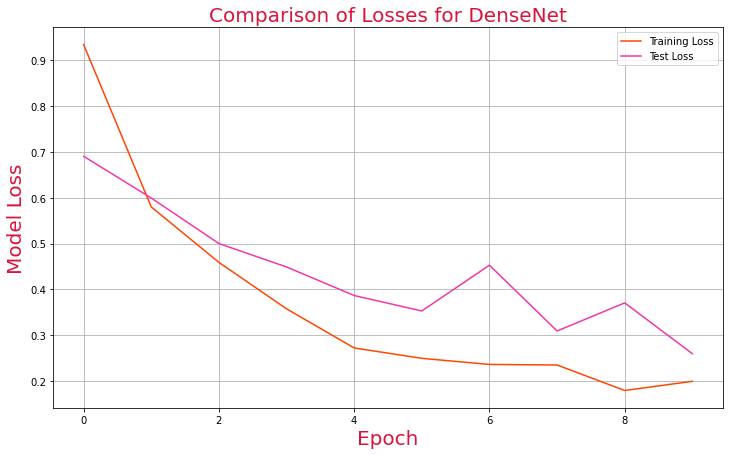

In [44]:
model_stat_den.iloc[:,1:3].plot(kind="line",figsize=(12,7),color=collist)
plt.title("Comparison of Losses for DenseNet",fontsize=20,color="#DC143C")
plt.xlabel("Epoch",fontsize=20,color="#DC143C")
plt.ylabel("Model Loss",fontsize=20,color="#DC143C")
plt.grid()
plt.show()

In [45]:
y_pred = model_den.predict(train_generator)
y_pred = np.argmax(y_pred, axis=1)
class_labels = train_generator.classes
den_out=pd.DataFrame({"Actual":class_labels,"Predicted":y_pred})
den_out["Actual"]=den_out["Actual"].replace(den_out["Actual"].unique(),['Covid', 'Normal', 'Viral Pneumonia'])
den_out["Predicted"]=den_out["Predicted"].replace(den_out["Predicted"].unique(),['Covid', 'Normal', 'Viral Pneumonia'])
prec.append(round(precision_score(den_out["Actual"], den_out["Predicted"], average='micro'),2)*100)     # Precision of the model
rcl.append(round(recall_score(den_out["Actual"], den_out["Predicted"], average='micro'),2)*100)     # Recall of the model
f1.append(round(f1_score(den_out["Actual"], den_out["Predicted"], average='micro'),2)*100)     # F1-Score of the model
acc.append(round(model_stat_den['Training Accuracy'].max(),4)*100)
print("Accuracy for DenseNet121 Model => {}".format(round(model_stat_den['Training Accuracy'].max(),4)*100))
ct_den=pd.crosstab(den_out["Actual"], den_out["Predicted"], rownames=['True'], colnames=['Predicted'], margins=True)
ct_den.iloc[:3,:3]

Accuracy for DenseNet121 Model => 95.22


Predicted        Covid  Normal  Viral Pneumonia
True                                           
Covid               29      31               51
Normal              22      18               30
Viral Pneumonia     22      18               30

['Covid', 'Normal', 'Viral Pneumonia']
Covid Affected Chest X-Ray Image


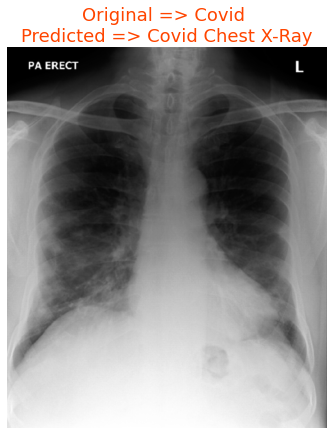

Normal Chest X-Ray Image


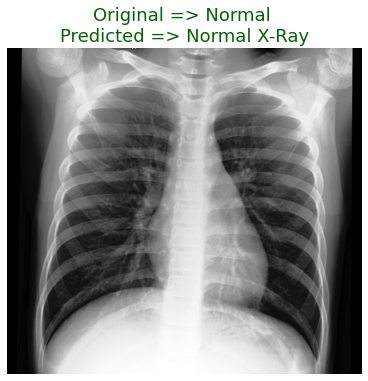

Covid Affected Chest X-Ray Image


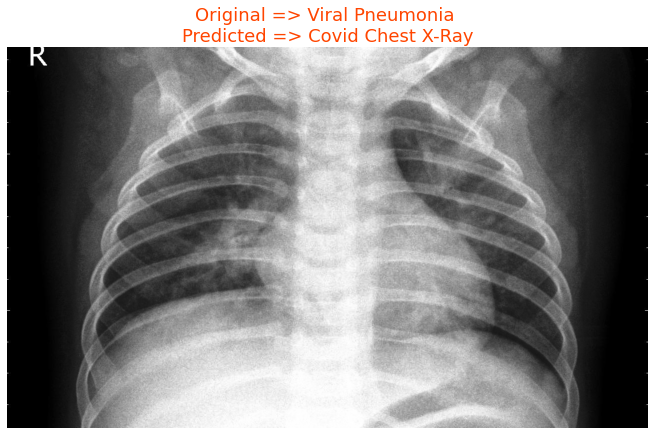

In [47]:
def chest_prediction(pres,dr):
    im = mpimg.imread(pres)
    img = image.load_img(pres,target_size=(img_h,img_w))
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis=0)
    pred=model_den.predict(img)
    pred_1=np.argmax(pred, axis=1)
    if pred_1[0]==0:
        print("Covid Affected Chest X-Ray Image")
        plt.figure(figsize=(14,7))
        picpred=imageio.imread(pres)
        plt.title("Original => {} \nPredicted => Covid Chest X-Ray".format(dr),fontsize=18,color="#FF4500")
        plt.imshow(picpred)
        plt.axis('off')
        plt.show()
    elif pred_1[0]==1:
        print("Normal Chest X-Ray Image")
        plt.figure(figsize=(12,6))
        picpred=imageio.imread(pres)
        plt.title("Original => {} \nPredicted => Normal X-Ray".format(dr),fontsize=18,color="#046307")
        plt.imshow(picpred)
        plt.axis('off')
        plt.show()
    elif pred_1[0]==2:
        print("Viral Pneumonia Affected Chest X-Ray Image")
        plt.figure(figsize=(12,6))
        picpred=imageio.imread(pres)
        plt.title("Original => {} \nPredicted => Viral Pneumonia Chest X-Ray".format(dr),fontsize=18,color="#DC143C")
        plt.imshow(picpred)
        plt.axis('off')
        plt.show()
    
lbldir=os.listdir(test_path)
print(lbldir)
pres=os.path.join(test_path,lbldir[0],os.listdir(test_path+"/"+lbldir[0])[1])
chest_prediction(pres,lbldir[0])
pres=os.path.join(test_path,lbldir[1],os.listdir(test_path+"/"+lbldir[1])[4])
chest_prediction(pres,lbldir[1])
pres=os.path.join(test_path,lbldir[2],os.listdir(test_path+"/"+lbldir[2])[4])
chest_prediction(pres,lbldir[2])

In [48]:
print("===========================================================")
print("===================== Training Accuracy ===================")
print("===========================================================")
print("Training Accuracy of CNN-2D: ",round(model_stat_sq['Training Accuracy'].max(),4)*100,"%")
print("Training Accuracy of VGG16: ",round(model_stat_vgg['Training Accuracy'].max(),4)*100,"%")
print("Training Accuracy of DenseNet121: ",round(model_stat_den['Training Accuracy'].max(),4)*100,"%")
print("===========================================================")
print("====================== Test Accuracy ======================")
print("===========================================================")
print("Test Accuracy of CNN-2D: ",round(model_stat_sq['Test Accuracy'].max(),4)*100,"%")
print("Test Accuracy of VGG16: ",round(model_stat_vgg['Test Accuracy'].max(),4)*100,"%")
print("Test Accuracy of DenseNet121: ",round(model_stat_den['Test Accuracy'].max(),4)*100,"%")
print("===========================================================")
print("====================== Training Loss ======================")
print("===========================================================")
print("Training Loss of CNN-2D: ",round(model_stat_sq['Training Loss'].min(),4)*100,"%")
print("Training Loss of VGG16: ",round(model_stat_vgg['Training Loss'].min(),4)*100,"%")
print("Training Loss of DenseNet121: ",round(model_stat_den['Training Loss'].min(),4)*100,"%")
print("===========================================================")
print("======================== Test Loss ========================")
print("===========================================================")
print("Test Loss of CNN-2D: ",round(model_stat_sq['Test Loss'].min(),4)*100,"%")
print("Test Loss of VGG16: ",round(model_stat_vgg['Test Loss'].min(),4)*100,"%")
print("Test Loss of DenseNet121: ",round(model_stat_den['Test Loss'].min(),4)*100,"%")
print("===========================================================")

===================== Training Accuracy ===================
Training Accuracy of CNN-2D:  74.5 %
Training Accuracy of VGG16:  96.02000000000001 %
Training Accuracy of DenseNet121:  95.22 %
====================== Test Accuracy ======================
Test Accuracy of CNN-2D:  72.72999999999999 %
Test Accuracy of VGG16:  93.94 %
Test Accuracy of DenseNet121:  89.39 %
====================== Training Loss ======================
Training Loss of CNN-2D:  61.980000000000004 %
Training Loss of VGG16:  12.61 %
Training Loss of DenseNet121:  18.0 %
======================== Test Loss ========================
Test Loss of CNN-2D:  56.8 %
Test Loss of VGG16:  20.68 %
Test Loss of DenseNet121:  26.009999999999998 %


In [49]:
model_den.save('pneumonia_model_den.h5')

In [50]:
XRAY_out=pd.DataFrame({
    "Algorithm":["CNN2D","VGG16","DenseNet121"],
    "Accuracy":acc,
    "Precision":prec,
    "Recall":rcl,
    "F1-Score":f1,
    
})

for i in XRAY_out.columns.tolist()[1:]:
    XRAY_out=XRAY_out.sort_values(by=i,ascending=Fals e)
    fig = px.bar(XRAY_out, y=i, x="Algorithm",color=i,title="Comparison of {}".format(i))
    fig.update_layout(
        font=dict(
            family="Times New Roman, Bold",
            size=20,
            color="black"
        )
    )
    fig.show()